### Statistical Arbitrage

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity='all'

import statsmodels.api as sm

# StatsModels for Ordinary Least Squares Regresssion 
import statsmodels.api as sm
# Import the adfuller (ADF) Stationarity Test 
from statsmodels.tsa.stattools import adfuller 
# Import QuantStats for Trading Strategy Tear-Sheets 
import quantstats as qs

In [3]:
sp500 = '^GSPC'
google = 'GOOG'
tickers = [sp500, google]

start = '2020-01-01' 
end= '2024-01-01'

df = pd.DataFrame(columns=tickers)
df[tickers[0]] = yf.download(sp500, start=start, end=end)['Adj Close']
df[tickers[1]] = yf.download(google, start=start, end=end)['Adj Close']

df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,^GSPC,GOOG
Date,,
2020-01-02,3257.850098,68.368500
2020-01-03,3234.850098,68.032997
2020-01-06,3246.280029,69.710503
2020-01-07,3237.179932,69.667000
2020-01-08,3253.050049,70.216003


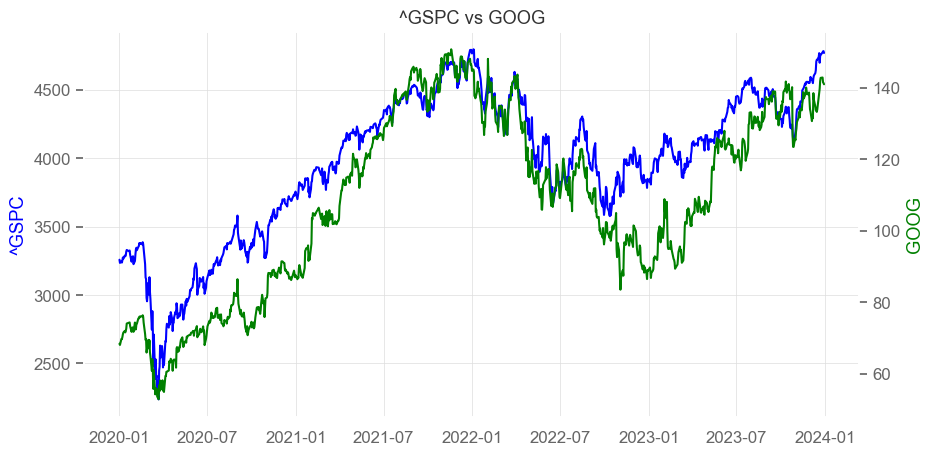

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df[tickers[0]], color='blue')
plt.ylabel(tickers[0], color='blue')
ax1 = ax.twinx()
ax1.plot(df.index, df[tickers[1]], color='green') 
plt.ylabel(tickers[1], color='green') 
plt.grid() 
plt.title(f'{tickers[0]} vs {tickers[1]}') 
plt.show();

Computing the Beta (Hedge Ratio for Google)

In [5]:
Y = df[tickers[0]]
x = df[tickers[1]]

X = sm.add_constant(x)
result = sm.OLS(Y, X).fit()

hedge_ratio = result.params[1]
print(f'Hedge Ratio: {hedge_ratio: .4f}')

Hedge Ratio:  19.5973


In [6]:
df['spread'] = Y - x * hedge_ratio

df['log_return'] = np.log(df['spread'] / df['spread'].shift(1))

df.head()

,^GSPC,GOOG,spread,log_return
Date,,,,
2020-01-02,3257.850098,68.368500,1918.008969,NaN
2020-01-03,3234.850098,68.032997,1901.583930,-0.008600
2020-01-06,3246.280029,69.710503,1880.139207,-0.011341
2020-01-07,3237.179932,69.667000,1871.891649,-0.004396
2020-01-08,3253.050049,70.216003,1877.002752,0.002727


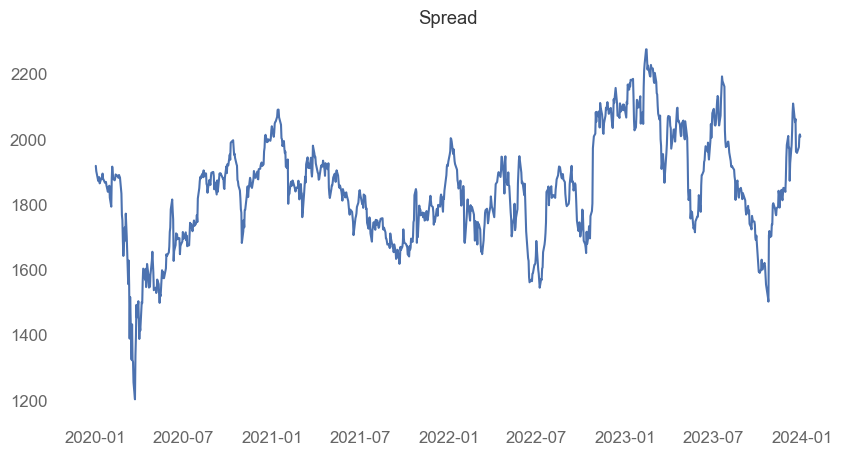

In [7]:
# Plot the Spread 
fig = plt.figure(figsize=(10,5)) 
plt.plot(df['spread']) 
plt.grid(False) 
plt.title('Spread') 
plt.show();

In [8]:
# Test the Spread for Stationarity using ADF 
adf = adfuller(df['spread'], maxlag=1) # p-value 
p_value = adf[1] 
# Print ADF Results 
print(f'ADF Result Parameters \n{adf}\n') 
# Print Test Statistic 
print(f'Test Statistic: {adf[0]:.4f}') 
# Print Critical Value 
print(f'Critical Value: {adf[4]["5%"]:.4f}') 
# Print P-Value 
print(f'P-Value: {adf[1]*100:.4f}%')

ADF Result Parameters 
(-3.330972113942134, 0.013549524424124791, 0, 1005, {'1%': -3.4368734638130847, '5%': -2.8644201518188126, '10%': -2.5683035273879358}, 9950.249190586503)

Test Statistic: -3.3310
Critical Value: -2.8644
P-Value: 1.3550%


In [9]:
# Compute Mean and Std using window specified 
window = 30 
df['mean'] = df['spread'].ewm(span=window).mean() 
df['std'] = df['spread'].ewm(span=window).std() 
# Drop NaN Values
df.dropna(inplace=True) 
# Compute the Z-Score 
df['z_score'] = ( df['spread'] - df['mean'] ) / df['std'] 
# Z-Score Boundaries 
df['z_up'] = 2.0 
df['z_down'] = -2.0 

df.head()

,^GSPC,GOOG,spread,log_return,mean,std,z_score,z_up,z_down
Date,,,,,,,,,
2020-01-03,3234.850098,68.032997,1901.583930,-0.008600,1909.522699,11.614257,-0.683537,2.0,-2.0
2020-01-06,3246.280029,69.710503,1880.139207,-0.011341,1899.068224,19.038827,-0.994232,2.0,-2.0
2020-01-07,3237.179932,69.667000,1871.891649,-0.004396,1891.580087,20.747219,-0.948968,2.0,-2.0
2020-01-08,3253.050049,70.216003,1877.002752,0.002727,1888.263391,18.937587,-0.594618,2.0,-2.0
2020-01-09,3274.699951,70.991501,1883.454963,0.003432,1887.322698,16.775340,-0.230561,2.0,-2.0


In [10]:
# Long Trading Signals 
long_entry = (df['z_score'] <= df['z_down']) 
long_exit = (df['z_score'] >= 0) 
# Initialize Long Position Column to NaN
df['long_pos'] = np.nan 
# Apply Long Trading Signals
df.loc[long_entry, 'long_pos'] = 1 
df.loc[long_exit, 'long_pos'] = 0 
# Forward Fill NaN Values 
df['long_pos'].fillna(method='ffill', inplace=True)
# Fill any remaining NaN values wth Zero
df['long_pos'].fillna(0, inplace=True)

In [11]:
# Short Trading Signals 
short_entry = (df['z_score'] >= df['z_up'])
short_exit = (df['z_score'] <= 0) 
# Initialize Short Position Column to NaN 
df['short_pos'] = np.nan 
# Apply Short Trading Signals 
df.loc[short_entry, 'short_pos'] = -1 
df.loc[short_exit, 'short_pos'] = 0 
# Forward Fill NaN Values 
df['short_pos'].fillna(method='ffill', inplace=True) 
# Fill any remaining NaN values wth Zero 
df['short_pos'].fillna(0, inplace=True)

In [12]:
# Total Trading Position 
df['total_pos'] = df['long_pos'] + df['short_pos'] 
df.head()

,^GSPC,GOOG,spread,log_return,mean,std,z_score,z_up,z_down,long_pos,short_pos,total_pos
Date,,,,,,,,,,,,
2020-01-03,3234.850098,68.032997,1901.583930,-0.008600,1909.522699,11.614257,-0.683537,2.0,-2.0,0.0,0.0,0.0
2020-01-06,3246.280029,69.710503,1880.139207,-0.011341,1899.068224,19.038827,-0.994232,2.0,-2.0,0.0,0.0,0.0
2020-01-07,3237.179932,69.667000,1871.891649,-0.004396,1891.580087,20.747219,-0.948968,2.0,-2.0,0.0,0.0,0.0
2020-01-08,3253.050049,70.216003,1877.002752,0.002727,1888.263391,18.937587,-0.594618,2.0,-2.0,0.0,0.0,0.0
2020-01-09,3274.699951,70.991501,1883.454963,0.003432,1887.322698,16.775340,-0.230561,2.0,-2.0,0.0,0.0,0.0


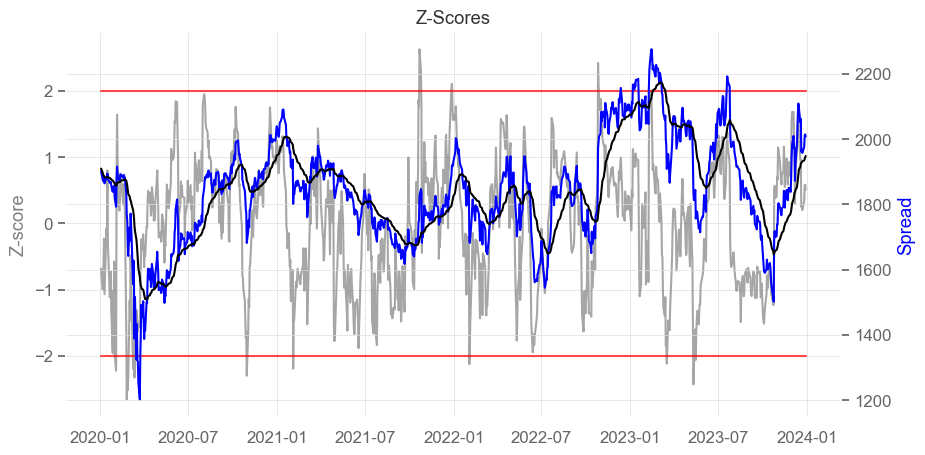

In [13]:
# Plot the Z-Scores 
fig, ax = plt.subplots(figsize=(10,5)) 
ax.plot(df.index, df['z_score'], color='grey', alpha=0.7) 
ax.plot(df.index, df['z_up'], color='red', alpha=0.7) 
ax.plot(df.index, df['z_down'], color='red', alpha=0.7) 
ax.set_ylabel('Z-score', color='grey') 
ax1 = ax.twinx() 
ax1.plot(df.index, df['spread'], color='blue') 
ax1.plot(df.index, df['mean'], color='black') 
ax1.set_ylabel('Spread', color='blue') 
plt.title('Z-Scores') 
plt.show();

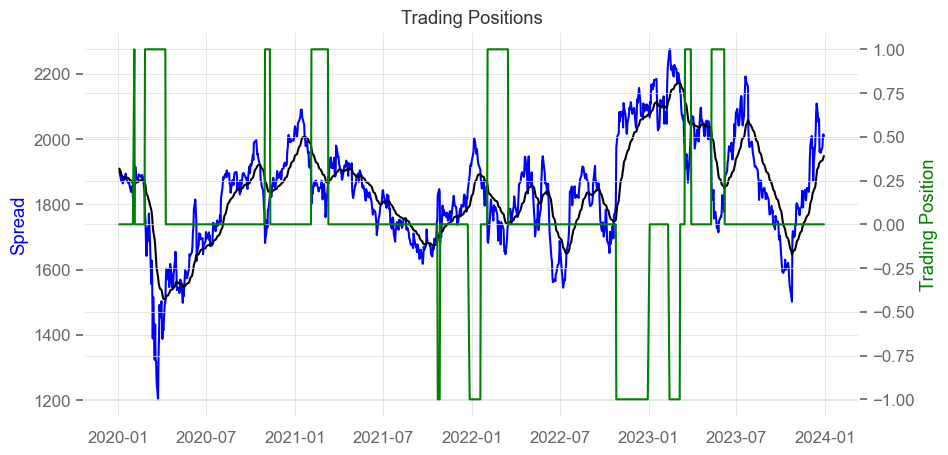

In [14]:
# Plot Trading Positions 
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(df.index, df['spread'], color='blue') 
plt.plot(df.index, df['mean'], color='black') 
plt.ylabel('Spread', color='blue') 
ax1 = ax.twinx() 
ax1.plot(df.index, df['total_pos'], color='green') 
ax1.set_ylabel('Trading Position', color='green') 
plt.title('Trading Positions') 
plt.show();

In [15]:
# Compute Strategy Returns - Shift Position by 1 Day to mitigate look-ah 
df['strategy_returns'] = df['total_pos'].shift(1) * df['log_return'] 
strategy_mean = df['strategy_returns'].mean() 
strategy_std = df['strategy_returns'].std() 
# Compute the Sharpe Ratio 
risk_free_rate = 0.05 # assume 5.0% per year 
# Daily Sharpe Ratio # Note: we convert risk-free rate to a daily rate i.e. divide by 252 
sharpe_daily = (strategy_mean - (risk_free_rate/252) ) / strategy_std 
print(f'Daily Sharpe Ratio: {sharpe_daily:.4f}') 
# Annualized Sharpe Ratio # Scale daily by t/sqrt(t) = sqrt(t) i.e. sqrt(252) 
sharpe_annual = sharpe_daily * np.sqrt(252)
print(f'Annual Sharpe Ratio: {sharpe_annual:.4f}')

Daily Sharpe Ratio: 0.0083
Annual Sharpe Ratio: 0.1323


                    Strategy
------------------  ----------
Start Period        2020-01-06
End Period          2023-12-29
Risk-Free Rate      5.0%
Time in Market      20.0%

Cumulative Return   25.16%
CAGR﹪              3.97%

Sharpe              0.14
Prob. Sharpe Ratio  20.87%
Sortino             0.2
Sortino/√2          0.14
Omega               1.06

Max Drawdown        -34.63%
Longest DD Days     609

Gain/Pain Ratio     0.18
Gain/Pain (1M)      1.08

Payoff Ratio        0.92
Profit Factor       1.18
Common Sense Ratio  1.49
CPC Index           0.61
Tail Ratio          1.27
Outlier Win Ratio   19.99
Outlier Loss Ratio  1.98

MTD                 0.0%
3M                  0.0%
6M                  0.0%
YTD                 17.32%
1Y                  16.66%
3Y (ann.)           6.48%
5Y (ann.)           3.97%
10Y (ann.)          3.97%
All-time (ann.)     3.97%

Avg. Drawdown       -9.32%
Avg. Drawdown Days  151
Recovery Factor     0.88
Ulcer Index         0.08
Serenity Index      0.26


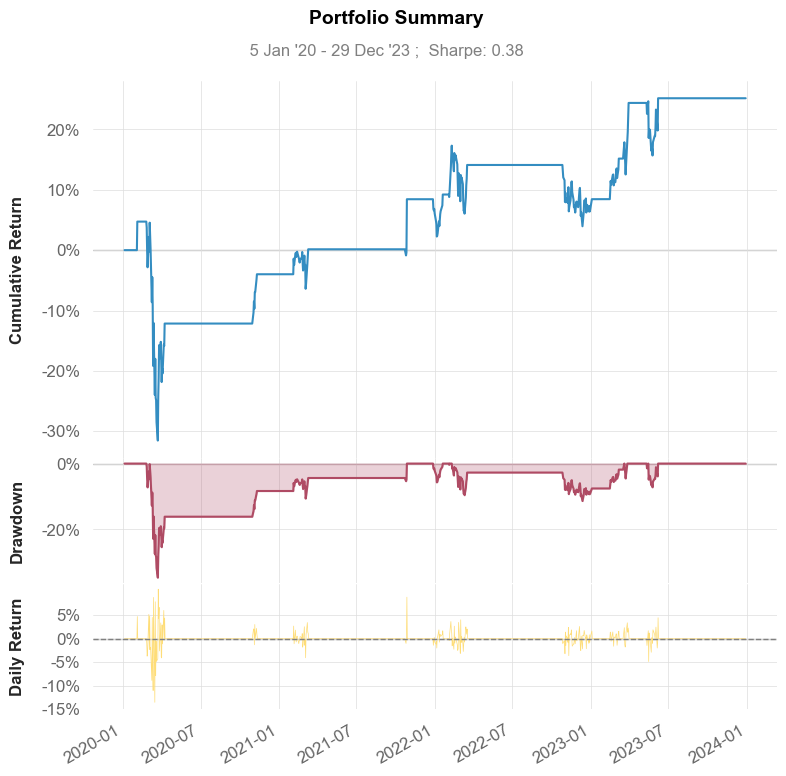

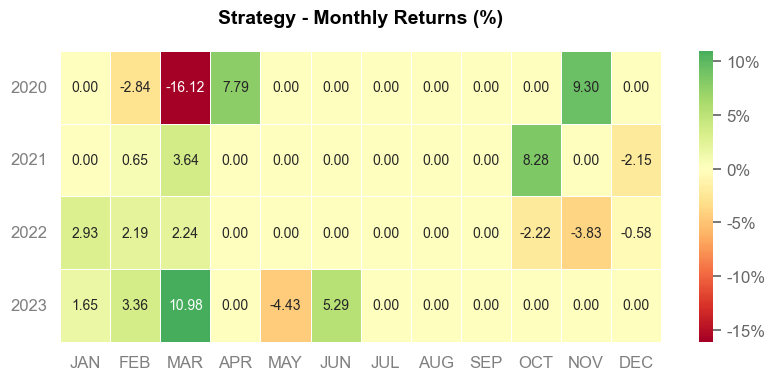

In [16]:
# QuantStats Tearsheet
qs.reports.basic(df['strategy_returns'], rf = risk_free_rate)